This notebook is meant to search for feasible $w$ vectors that get the objective function in the right order of magnitutde. Ideas to explore:
1. Generate Random $w$ vectors and pick the one that makes the endpoint the smallest.
2. Optimize $w$ using some kind of numerical optimizer.

The lower endpoint is defined by
\begin{equation}
    f(w) = w^T y - \psi_\alpha \lVert w \rVert_2 - b^T c
\end{equation}

In [1]:
import cvxpy as cp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from scipy import stats
from scipy.optimize import minimize
from tqdm.notebook import tqdm

In [2]:
from generate_opt_objects import A_b_generation

**PNC:/Users/mikestanley/anaconda3/envs/mc_sampling/lib/python3.8/site-packages/PseudoNetCDF/pncwarn.py:24:UserWarning:
  pyproj could not be found, so IO/API coordinates cannot be converted to lat/lon; to fix, install pyproj or basemap (e.g., `pip install pyproj)`


In [3]:
BASE_DIR = '/Users/mikestanley/Research/Carbon_Flux'
BASE_DIR += '/optimization/src_admm/data/carbon_flux/objects'

# Read in objects

In [4]:
# y vector
with open(BASE_DIR + '/y_affine_corrected.npy', 'rb') as f:
    y_obs = np.load(f)
    
# gosat data
with open(BASE_DIR + '/gosat_df_jan1_aug31_2010.csv', 'rb') as f:
    gosat_df = pd.read_csv(f)
L_inv_vec = 1 / gosat_df.xco2_unc.values
    
# tranform the data
y_tilde = np.multiply(L_inv_vec, y_obs)

In [5]:
# psi_alpha
with open(BASE_DIR + '/opt_res_cont.pkl', 'rb') as f:
    opt_slack = pickle.load(f)
    
PSI_ALPHA = np.sqrt(stats.chi2.ppf(q=.95, df=1) + opt_slack[1])

In [6]:
# b
A, b = A_b_generation(
    box_constraint_fp=BASE_DIR + '/scipy_bnds.pkl'
)

In [7]:
# h
with open(BASE_DIR + '/na_june_functional.npy', 'rb') as f:
    h = np.load(f)

In [8]:
# c
with open(BASE_DIR + '/../results/02/opt_output_07.pkl', 'rb') as f:
    opt_res = pickle.load(f)
    
c = opt_res['c_opt_vecs'][7, :].copy()
w_opt = opt_res['w_opt_vecs'][7, :]

In [9]:
# function value
np.dot(w_opt, y_tilde) - PSI_ALPHA * np.linalg.norm(w_opt) - np.dot(b, c)

-53312.42172451793

# Compare `w_opt` with `w_start`

`w_opt` looks suspiciously Gaussian. How much did it change from `w_start`?

In [18]:
# generate starting point used for the optimization
np.random.seed(12345)
w_sp = stats.norm().rvs(w_opt.shape[0])

In [19]:
np.linalg.norm(w_sp - w_opt)

20.494603905295776

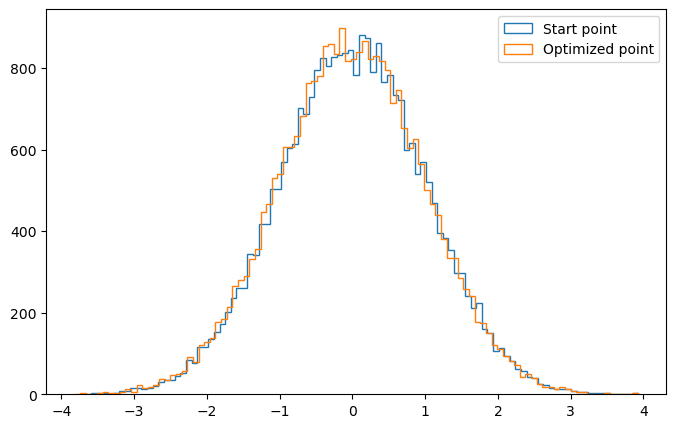

In [22]:
plt.figure(figsize=(8, 5))
plt.hist(w_sp, bins=100, histtype='step', label='Start point')
plt.hist(w_opt, bins=100, histtype='step', label='Optimized point')
plt.legend()
plt.show()

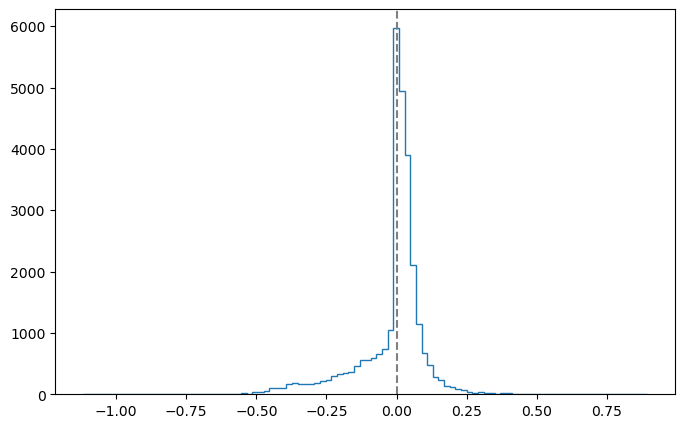

In [23]:
plt.figure(figsize=(8, 5))
plt.hist(w_opt - w_sp, bins=100, histtype='step')
plt.axvline(0, linestyle='--', color='gray')
plt.show()

In [24]:
w_opt - w_sp

array([-1.09156451e-04,  2.30075968e-03,  8.06586649e-04, ...,
       -1.63372239e-01, -1.81981686e-01, -1.84827939e-01])

# Targeting particular coordinates for optimization

In [63]:
import statsmodels.api as sm
from sklearn.preprocessing import scale

In [37]:
# define target
delta_w = w_opt - w_sp

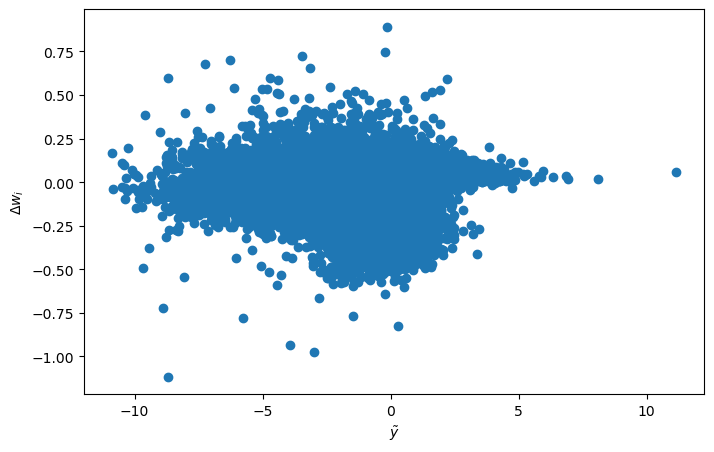

In [38]:
plt.figure(figsize=(8, 5))
plt.scatter(y_tilde, delta_w)
plt.xlabel(r'$\tilde{y}$')
plt.ylabel(r'$\Delta w_i$')
plt.show()

### Investigating Spatial Correlation

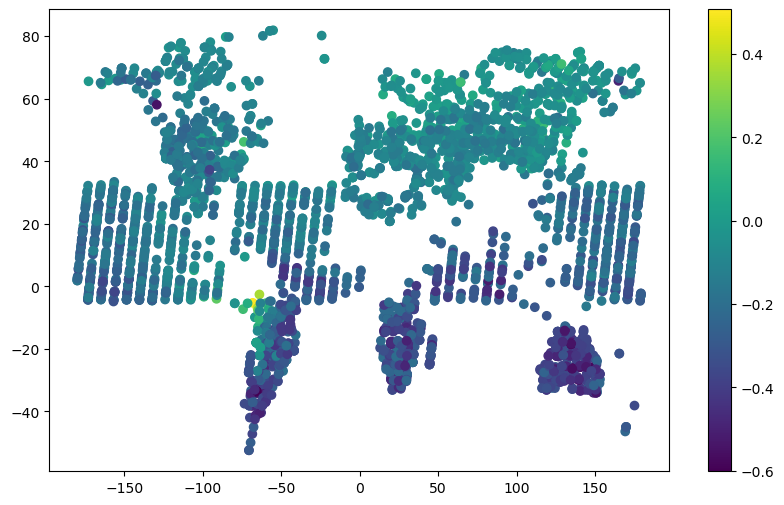

In [44]:
MONTH_IDXS = gosat_df['month'] == 8
plt.figure(figsize=(10, 6))
plt.scatter(gosat_df['lon'][MONTH_IDXS], gosat_df['lat'][MONTH_IDXS], c=delta_w[MONTH_IDXS])
plt.colorbar()
plt.show()

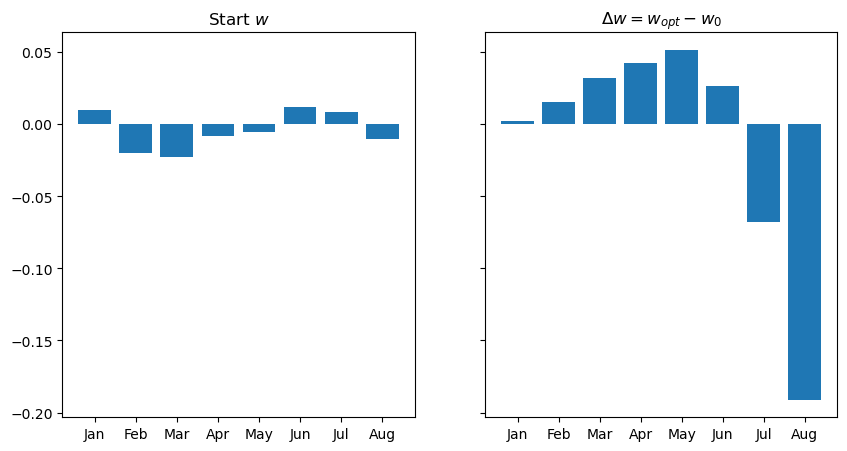

In [79]:
# do different months have different delta w's?
gosat_df['delta_w'] = delta_w
gosat_df['w_sp'] = w_sp
month_deltas = gosat_df.groupby('month')['delta_w'].mean()
month_w_sp = gosat_df.groupby('month')['w_sp'].mean()

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(10, 5), sharey=True)
ax[0].bar(x=month_w_sp.index, height=month_w_sp)
ax[1].bar(x=month_deltas.index, height=month_deltas)

for i in range(2):
    ax[i].set_xticks(np.arange(1, 9))
    ax[i].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug'])

ax[0].set_title(r'Start $w$')
ax[1].set_title(r'$\Delta w = w_{opt} - w_0$')
plt.show()

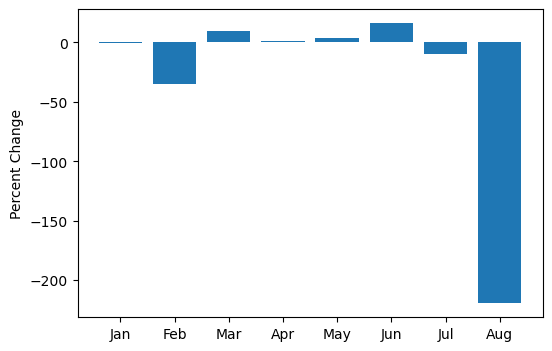

In [87]:
# look at percent change of w
gosat_df['w_pch'] = gosat_df['delta_w'] / gosat_df['w_sp']
month_pch = gosat_df.groupby('month')['w_pch'].mean()

plt.figure(figsize=(6, 4))
plt.bar(x=month_pch.index, height=month_pch * 100)
plt.ylabel('Percent Change')
plt.xticks(ticks=np.arange(1, 9), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug'])
plt.show()

In [92]:
gosat_df['w_opt'] = w_opt
print(gosat_df.groupby('month')['w_opt'].mean())

month
1.0    0.011958
2.0   -0.005180
3.0    0.009016
4.0    0.033570
5.0    0.046011
6.0    0.037751
7.0   -0.060064
8.0   -0.201528
Name: w_opt, dtype: float64


In [90]:
# build data
X = gosat_df[['lon', 'lat', 'w_sp']].values
X = np.hstack((X, y_tilde[:, np.newaxis]))
X = scale(X)
X = np.hstack((X, pd.get_dummies(gosat_df['month']).values))

# fit model
mod = sm.GLS(endog=gosat_df['delta_w'].values, exog=X)
res_lin = mod.fit()
print(res_lin.summary())

                            GLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.589
Model:                            GLS   Adj. R-squared:                  0.589
Method:                 Least Squares   F-statistic:                     3683.
Date:                Tue, 31 Oct 2023   Prob (F-statistic):               0.00
Time:                        15:17:05   Log-Likelihood:                 32202.
No. Observations:               28267   AIC:                        -6.438e+04
Df Residuals:                   28255   BIC:                        -6.428e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0070      0.000    -14.966      0.0

# Explore functional values

In [10]:
def f_w(w, y=y_tilde, psi_alpha=PSI_ALPHA, b=b, c=c):
    """ Lower endpoint functional """
    return np.dot(w, y) - psi_alpha * np.linalg.norm(w) - np.dot(b, c)

In [11]:
# define constants
n = y_tilde.shape[0]
print(n)

28267


In [11]:
N = 1000 # number of loops
M = 100  # number of observations each loop
endpoint_values = np.zeros(N * M)
count = 0
for i in tqdm(range(N)):
    np.random.seed(count)
    gaussian_draws = stats.norm(0, 1).rvs(M * n).reshape((M, n))
    for j in range(M):
        endpoint_values[count] = f_w(w=gaussian_draws[j, :])
        count += 1

  0%|          | 0/1000 [00:00<?, ?it/s]

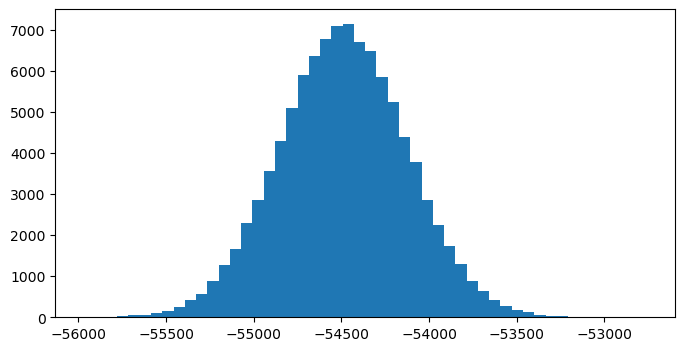

In [12]:
plt.figure(figsize=(8, 4))
plt.hist(endpoint_values, bins=50)
plt.show()

# With $c$ set to zero

In [13]:
N = 1000 # number of loops
M = 100  # number of observations each loop
endpoint_values_c0 = np.zeros(N * M)
count = 0
for i in tqdm(range(N)):
    np.random.seed(count)
    gaussian_draws = stats.norm(0, 1).rvs(M * n).reshape((M, n))
    for j in range(M):
        endpoint_values_c0[count] = f_w(w=gaussian_draws[j, :], c=np.zeros_like(c))
        count += 1

  0%|          | 0/1000 [00:00<?, ?it/s]

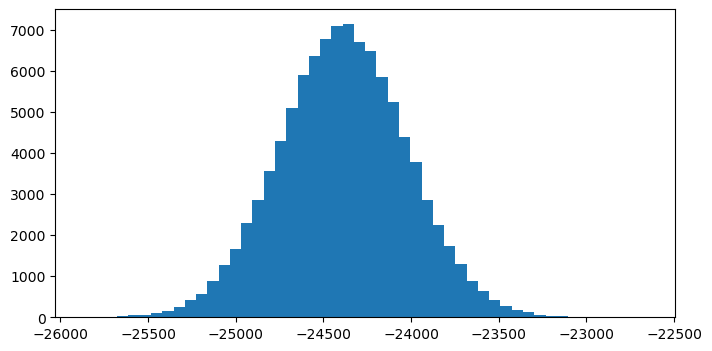

In [14]:
plt.figure(figsize=(8, 4))
plt.hist(endpoint_values_c0, bins=50)
plt.show()

# Numerical optimization of $w$

Ways to frame this:
1. Feasibility problem...find $w$ such that endpoint is $0$
2. Maximize the endpoint with amortized $K^T w$

### Feasibility Problem

In [21]:
w_feas = cp.Variable(n)
constraints_feas = [w_feas @ y_tilde - PSI_ALPHA * cp.norm2(w_feas) - np.dot(b, c) <= 0]
prob_feas = cp.Problem(objective=cp.Minimize(0), constraints=constraints_feas)
prob_feas.solve(solver=cp.ECOS)

DCPError: Problem does not follow DCP rules. Specifically:
The following constraints are not DCP:
var57 @ [-0.23940673  1.77075846 -0.10841645 ... -3.02471118 -3.87350239
 -4.79224736] + -145.0614723275884 @ Pnorm(var57, 2) + -30102.20716575939 <= 0.0 , because the following subexpressions are not:
|--  var57 @ [-0.23940673  1.77075846 -0.10841645 ... -3.02471118 -3.87350239
 -4.79224736] + -145.0614723275884 @ Pnorm(var57, 2) + -30102.20716575939 <= 0.0

### Maximizing the endpoint subject to some constraint

We weight observations according to their month delta (as seen in `month_deltas`). $\Delta w < 0 $ should indicate downweight while $\Delta w > 0$ should indicate upweight. More precisely, let $\gamma_i$ be the weight applied to the $i$ coordinate of $w$. The constraint then takes the form $\sum_i \gamma_i w_i^2 \leq t$. If $\Delta w_i = 0$, $\gamma_i = 1$, if $\Delta w_i > 0$, $\gamma_i > 1$, and $\Delta w_i < 0$, $\gamma_i < 1$. This scheme is achieved by setting $\gamma_i := \exp(\alpha \Delta w_i)$, where $\alpha$ is another control to allow further prioritization of the weights.

In [135]:
# attach column with monthly delta
gosat_df = gosat_df.join(month_deltas, on='month', how='left', lsuffix='_point', rsuffix='_month')

# apply exp
alpha = 2  # weight severity
gosat_df['delta_w_month'] = np.exp(alpha * gosat_df['delta_w_month'])

In [173]:
t_ub = 922.4685  # hyperparameter on optimization
w_max = cp.Variable(n)
prob_max = cp.Problem(
    objective=cp.Maximize(w_max @ y_tilde - PSI_ALPHA * cp.norm2(w_max) - np.dot(b, c)),
    constraints=[
        cp.norm2(cp.multiply(w_max, gosat_df['delta_w_month'])) <= t_ub
    ]
)
prob_max.solve(solver=cp.SCS)

-0.41588500069337897

In [175]:
SAVE_DIR = '/Users/mikestanley/Research/Carbon_Flux'
SAVE_DIR += '/optimization/src_admm/data/carbon_flux/objects'
with open(SAVE_DIR + '/w_vec_max.npy', 'wb') as f:
    np.save(file=f, arr=w_max.value)

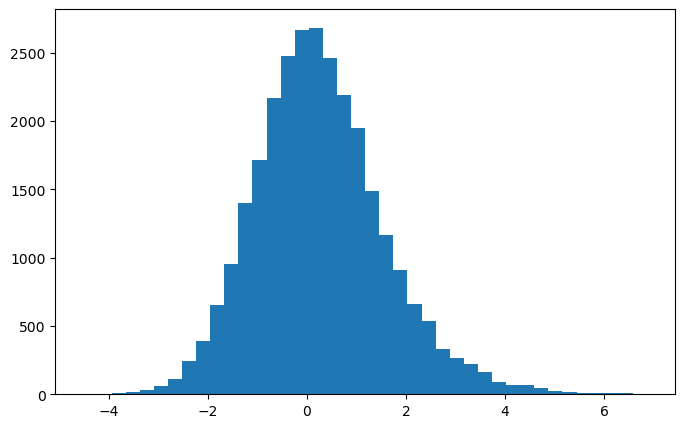

In [170]:
plt.figure(figsize=(8, 5))
plt.hist(w_opt - w_max.value, bins=40)
plt.show()

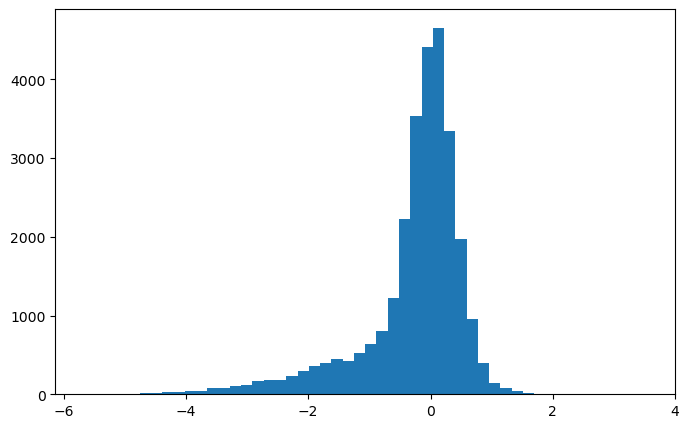

In [171]:
plt.figure(figsize=(8, 5))
plt.hist(w_max.value, bins=50)
plt.show()